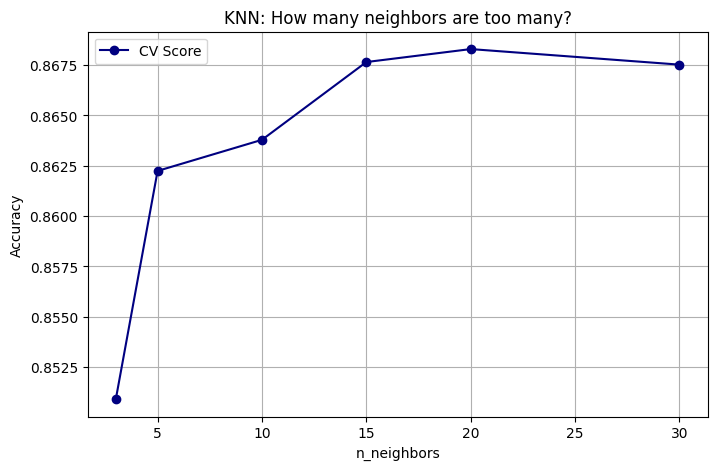

Analyzing: Accuracy vs. Number of PCA Components


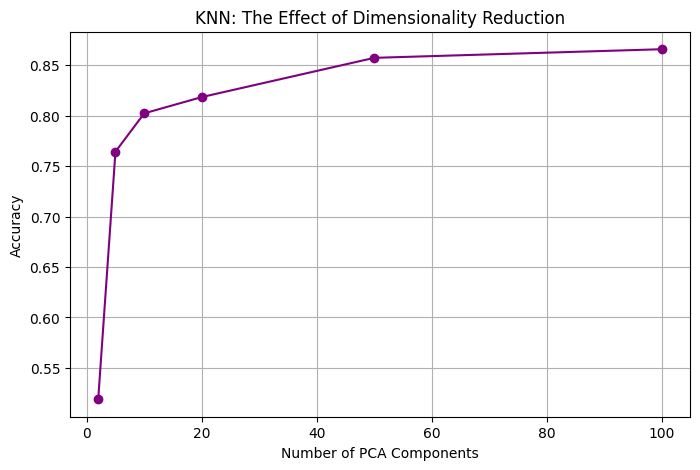

Does KNN need Frequency features?
Time-Only Accuracy: 0.8707
Freq-Only Accuracy: 0.7413
Combined Accuracy: 0.8722
Visualizing: Do Time or Freq features separate clusters better?


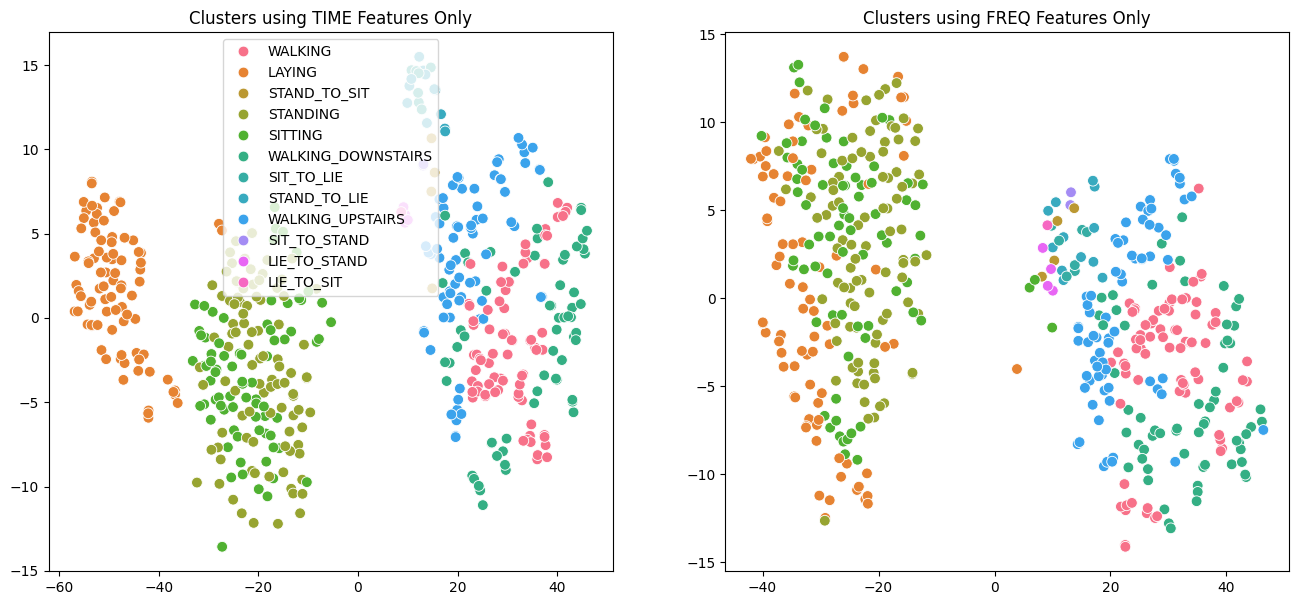

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

label_map = {
    1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS',
    4:'SITTING', 5:'STANDING', 6:'LAYING',
    7:'STAND_TO_SIT', 8:'SIT_TO_STAND', 9:'SIT_TO_LIE',
    10:'LIE_TO_SIT', 11:'STAND_TO_LIE', 12:'LIE_TO_STAND'
}

def decode_names(y_encoded):
    original = le.inverse_transform(y_encoded)
    return [label_map[int(v)] for v in original]

train_df = pd.read_csv('../../data/activity_train.csv')
test_df = pd.read_csv('../../data/activity_test.csv')

le = LabelEncoder()

# Drop subject/target
X_train = train_df.drop(columns=['activity', 'subject'], errors='ignore')
y_train = le.fit_transform(train_df['activity'])
X_test = test_df.drop(columns=['activity', 'subject'], errors='ignore')
y_test = le.fit_transform(test_df['activity'])

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

k_range = [3, 5, 10, 15, 20, 30]
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(weights='distance'), # Distance weights usually better for high-dim
    X_train_scaled, y_train, 
    param_name="n_neighbors", param_range=k_range,
    cv=3, scoring="accuracy", n_jobs=-1
)

plt.figure(figsize=(8, 5))
plt.plot(k_range, np.mean(test_scores, axis=1), marker='o', label='CV Score', color='navy')
plt.title("KNN: How many neighbors are too many?")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# --- ---

print("Analyzing: Accuracy vs. Number of PCA Components")
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

accs = []
n_components = [2, 5, 10, 20, 50, 100]
knn_pca = KNeighborsClassifier(n_neighbors=10, weights='distance')

for n in n_components:
    knn_pca.fit(X_train_pca[:, :n], y_train)
    accs.append(knn_pca.score(X_test_pca[:, :n], y_test))

plt.figure(figsize=(8, 5))
plt.plot(n_components, accs, marker='o', color='purple')
plt.title("KNN: The Effect of Dimensionality Reduction")
plt.xlabel("Number of PCA Components")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

print("Does KNN need Frequency features?")
t_cols = [c for c in X_train.columns if c.startswith('t')]
f_cols = [c for c in X_train.columns if c.startswith('f')]

datasets = {"Time-Only": t_cols, "Freq-Only": f_cols, "Combined": X_train.columns}
knn_best = KNeighborsClassifier(n_neighbors=10, weights='distance') # Use a decent default

for name, cols in datasets.items():
    knn_best.fit(X_train_scaled[cols], y_train)
    acc = knn_best.score(X_test_scaled[cols], y_test)
    print(f"{name} Accuracy: {acc:.4f}")

print("Visualizing: Do Time or Freq features separate clusters better?")
# We take a random subset of 500 points to make t-SNE fast
subset_idx = np.random.choice(len(X_test_scaled), 500, replace=False)
X_sub = X_test_scaled.iloc[subset_idx]
y_sub = y_test[subset_idx]

# Split features
t_data = X_sub[[c for c in X_sub.columns if c.startswith('t')]]
f_data = X_sub[[c for c in X_sub.columns if c.startswith('f')]]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

labels_sub = decode_names(y_sub)

# Plot Time Domain Clusters
tsne_t = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(t_data)
sns.scatterplot(x=tsne_t[:,0], y=tsne_t[:,1], hue=labels_sub, ax=axes[0], s=60)
axes[0].set_title("Clusters using TIME Features Only")

# Plot Freq Domain Clusters
tsne_f = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(f_data)
sns.scatterplot(x=tsne_f[:,0], y=tsne_f[:,1], hue=labels_sub, ax=axes[1], s=60, legend=False)
axes[1].set_title("Clusters using FREQ Features Only")

plt.show()